In [20]:
import random
import time
import matplotlib.pyplot as plt
import heapq
import numpy as np
random.seed(14)

In [21]:
# Допоміжні функції
def find_zero(state):
    for i, row in enumerate(state):
        for j, val in enumerate(row):
            if val == 0:
                return i, j

def copy_state(state):
    return [row[:] for row in state]

def h1(state):
    goal_state = [
        [1, 2, 3],
        [4, 5, 6],
        [7, 8, 0]
    ]
    count = 0
    for i in range(3):
        for j in range(3):
            if state[i][j] != 0 and state[i][j] != goal_state[i][j]:
                count += 1
    return count

def generate_neighbors(state):
    neighbors = []
    x, y = find_zero(state)
    moves = [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]  # зверху, знизу, зліва, зправа

    for move in moves:
        if 0 <= move[0] < 3 and 0 <= move[1] < 3:
            new_state = copy_state(state)
            new_state[x][y], new_state[move[0]][move[1]] = new_state[move[0]][move[1]], new_state[x][y]
            neighbors.append(new_state)

    return neighbors

In [22]:
# Алгоритм LDFS
def LDFS(state, goal, depth, limit, nodes_generated, max_nodes_in_memory, path=[]):
    nodes_generated[0] += 1
    max_nodes_in_memory[0] = max(max_nodes_in_memory[0], len(path))
    
    if state == goal:
        return path + [state]

    if depth == limit:
        return None

    for neighbor in generate_neighbors(state):
        if neighbor not in path: 
            result = LDFS(neighbor, goal, depth + 1, limit, nodes_generated, max_nodes_in_memory, path + [state])
            if result is not None:
                return result

    return None

In [23]:
# Функція для перемішування початкового стану
def shuffle_state(state, moves=100):
    for _ in range(moves):
        neighbors = generate_neighbors(state)
        state = random.choice(neighbors)
    return state

# Функція для виконання експерименту
def run_experiment(initial_state, goal_state, limit):
    start_time = time.time()
    nodes_generated = [0]
    max_nodes_in_memory = [0]
    result = LDFS(initial_state, goal_state, 0, limit, nodes_generated, max_nodes_in_memory)
    end_time = time.time()
    return {
        "initial_state": initial_state,
        "time": end_time - start_time,
        "nodes_generated": nodes_generated[0],
        "max_nodes_in_memory": max_nodes_in_memory[0],
        "result": "Success" if result else "Failure",
        "solution_depth": len(result) if result else 0
    }

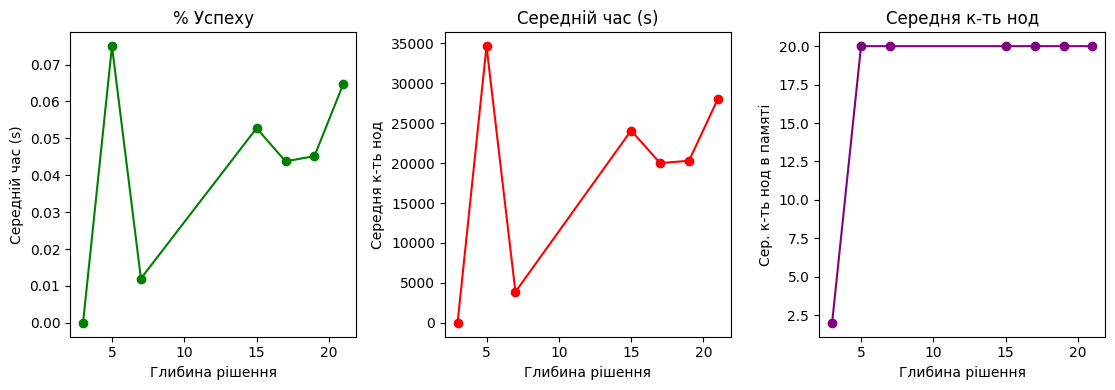

In [24]:
# запуск 
goal_state = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 0]
]

def analyze_results(steps_range, success_rates, avg_times, avg_nodes_generated, avg_max_nodes_in_memory, avg_solution_depths):
    threshold = 0.01
    optimal_steps = None
    for i in range(1, len(success_rates)):
        if success_rates[i] - success_rates[i-1] < threshold:
            optimal_steps = steps_range[i]
            break
    
    if not optimal_steps:
        optimal_steps = steps_range[-1]

    print(f"Optimal Step Limit: {optimal_steps}")
    print(f"Success Rate at Optimal Steps: {success_rates[optimal_steps//2 - 1]}")
    print(f"Average Time at Optimal Steps: {avg_times[optimal_steps//2 - 1]} seconds")
    print(f"Average Nodes Generated at Optimal Steps: {avg_nodes_generated[optimal_steps//2 - 1]}")
    print(f"Average Max Nodes in Memory at Optimal Steps: {avg_max_nodes_in_memory[optimal_steps//2 - 1]}")
    print(f"Average Solution Depth at Optimal Steps: {avg_solution_depths[optimal_steps//2 - 1]}")


from collections import defaultdict
def run_experiments(goal_state, num_experiments):
    # Словари для сбора значений по каждой глубине решения
    depth_data = defaultdict(lambda: defaultdict(list))

    for _ in range(num_experiments):
        initial_state = shuffle_state(goal_state, moves=20)
        experiment_result = run_experiment(initial_state, goal_state, limit=20)

        depth = experiment_result['solution_depth']
        depth_data[depth]['success_rates'].append(1 if experiment_result['result'] == 'Success' else 0)
        depth_data[depth]['avg_times'].append(experiment_result['time'])
        depth_data[depth]['avg_nodes_generated'].append(experiment_result['nodes_generated'])
        depth_data[depth]['avg_max_nodes_in_memory'].append(experiment_result['max_nodes_in_memory'])

    # Сортированные уникальные глубины решения
    unique_depths = sorted(depth_data.keys())
    
    # Средние значения для каждой метрики и каждой глубины
    avg_success_rates = [np.mean(depth_data[d]['success_rates']) for d in unique_depths]
    avg_times = [np.mean(depth_data[d]['avg_times']) for d in unique_depths]
    avg_nodes_generated = [np.mean(depth_data[d]['avg_nodes_generated']) for d in unique_depths]
    avg_max_nodes_in_memory = [np.mean(depth_data[d]['avg_max_nodes_in_memory']) for d in unique_depths]

    plt.figure(figsize=(15, 4))

    # Список метрик для графиков
    metrics = [
        (avg_times, 'Середній час (s)', 'green'),
        (avg_nodes_generated, 'Середня к-ть нод', 'red'),
        (avg_max_nodes_in_memory, 'Сер. к-ть нод в памяті', 'purple'),
    ]
    
    titles = ['% Успеху', 'Середній час (s)', 'Середня к-ть нод', 'Сер. к-ть нод в памяті']
    
    # Построение графиков
    for i, (data, label, color) in enumerate(metrics, 1):
        plt.subplot(1, 4, i)
        plt.plot(unique_depths, data, marker='o', linestyle='-', color=color)
        plt.xlabel('Глибина рішення')
        plt.ylabel(label)
        plt.title(titles[i-1])

    plt.tight_layout()
    plt.show()

# Запуск экспериментов
run_experiments(goal_state, 50)

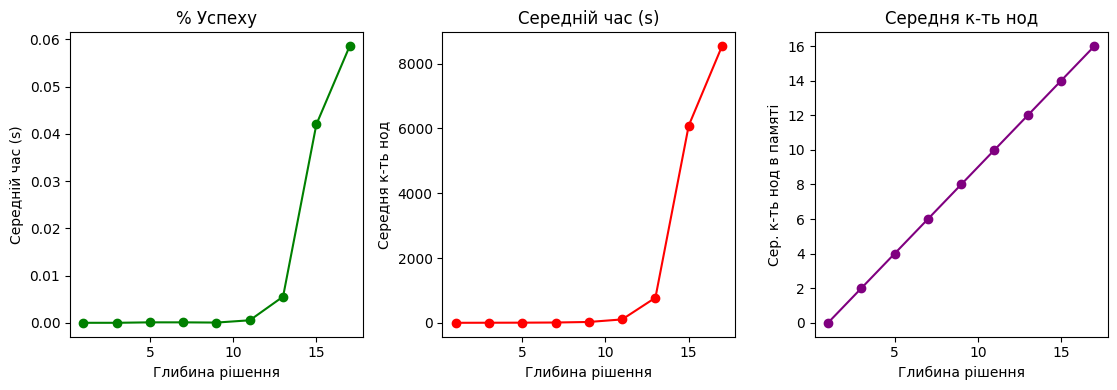

In [25]:
def RBFS(state, goal, f_limit, g, nodes_generated, max_nodes_in_memory, path=[]):
    nodes_generated[0] += 1
    max_nodes_in_memory[0] = max(max_nodes_in_memory[0], len(path))

    if state == goal:
        return path + [state], 0

    neighbors = generate_neighbors(state)
    if not neighbors:
        return None, float('inf')

    f_values = []
    for neighbor in neighbors:
        h = h1(neighbor)
        f = g + 1 + h
        heapq.heappush(f_values, (f, neighbor))

    while f_values:
        f, best_neighbor = heapq.heappop(f_values)
        if f > f_limit:
            return None, f

        if best_neighbor not in path:
            result, new_f = RBFS(best_neighbor, goal, min(f_limit, f), g + 1, nodes_generated, max_nodes_in_memory, path + [state])
            if result is not None:
                return result, new_f
            heapq.heappush(f_values, (new_f, best_neighbor))

    return None, float('inf')

def run_experimentRBFS(initial_state, goal_state):
    start_time = time.time()
    nodes_generated = [0]
    max_nodes_in_memory = [0]
    result, _ = RBFS(initial_state, goal_state, float('inf'), 0, nodes_generated, max_nodes_in_memory)
    end_time = time.time()
    return {
        "initial_state": initial_state,
        "time": end_time - start_time,
        "nodes_generated": nodes_generated[0],
        "max_nodes_in_memory": max_nodes_in_memory[0],
        "result": "Success" if result else "Failure",
        "solution_depth": len(result) if result else 0
    }

def run_experimentsRBFS(goal_state, num_experiments):
    depth_data = defaultdict(lambda: defaultdict(list))

    for _ in range(num_experiments):
        initial_state = shuffle_state(goal_state, moves=20)
        experiment_result = run_experimentRBFS(initial_state, goal_state)

        depth = experiment_result['solution_depth']
        depth_data[depth]['success_rates'].append(1 if experiment_result['result'] == 'Success' else 0)
        depth_data[depth]['avg_times'].append(experiment_result['time'])
        depth_data[depth]['avg_nodes_generated'].append(experiment_result['nodes_generated'])
        depth_data[depth]['avg_max_nodes_in_memory'].append(experiment_result['max_nodes_in_memory'])

    # Сортированные уникальные глубины решения
    unique_depths = sorted(depth_data.keys())
    
    # Средние значения для каждой метрики и каждой глубины
    avg_times = [np.mean(depth_data[d]['avg_times']) for d in unique_depths]
    avg_nodes_generated = [np.mean(depth_data[d]['avg_nodes_generated']) for d in unique_depths]
    avg_max_nodes_in_memory = [np.mean(depth_data[d]['avg_max_nodes_in_memory']) for d in unique_depths]

    plt.figure(figsize=(15, 4))

    # Список метрик для графиков
    metrics = [
        (avg_times, 'Середній час (s)', 'green'),
        (avg_nodes_generated, 'Середня к-ть нод', 'red'),
        (avg_max_nodes_in_memory, 'Сер. к-ть нод в памяті', 'purple'),
    ]
    
    titles = ['% Успеху', 'Середній час (s)', 'Середня к-ть нод', 'Сер. к-ть нод в памяті']
    
    # Построение графиков
    for i, (data, label, color) in enumerate(metrics, 1):
        plt.subplot(1, 4, i)
        plt.plot(unique_depths, data, marker='o', linestyle='-', color=color)
        plt.xlabel('Глибина рішення')
        plt.ylabel(label)
        plt.title(titles[i-1])

    plt.tight_layout()
    plt.show()

run_experimentsRBFS(goal_state, 200)